

---



* 원본 코드: [Basic regression: Predict fuel efficiency](https://www.tensorflow.org/tutorials/keras/regression)
* 수정자: 한양대ERICA, 산업경영공학과, 오요셉(yosepoh@hanyang.ac.kr)
* 마지막 수정일: 2023.02.07


---



# (1) Preliminaries

In [ ]:
# 데이터 시각화 패키지 Seaborn 설치
!pip install seaborn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 데이터 전처리 패키지
import numpy as np
import pandas as pd

# 데이터 시각화 패키지
import matplotlib.pyplot as plt 
import seaborn as sns 

# 머신러닝 패키지
import tensorflow as tf 
from keras import layers 

# (2) Load the dataset 

In [ ]:
# 데이터셋 다운로드 및 데이터프레임에 저장
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ',  skipinitialspace=True)

# 데이터 전처리
dataset = raw_dataset.copy()
dataset.isna().sum()
dataset = dataset.dropna()  

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [ ]:
# 원-핫 인코딩(One-Hot Encoding)
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [ ]:
# 데이터를 훈련 세트와 테스트 세트로 분할
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# 입력변수(X)와 출력변수(y) 구분
train_X = train_dataset.copy()
test_X = test_dataset.copy()
train_y = train_X.pop('MPG')
test_y = test_X.pop('MPG')

# 훈련 세트와 테스트 세트가 잘 분할되었는지 확인
print(len(train_X))
print(len(test_X))

314
78


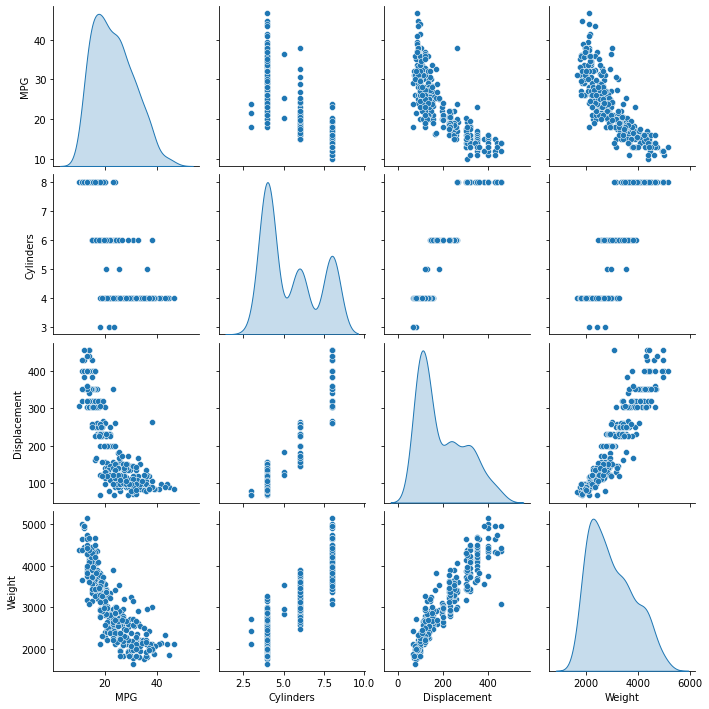

In [ ]:
# 데이터 시각화를 통한 변수간 관계 파악
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [ ]:
# 기초 통계를 통한 데이터 특성 파악
# .transpose()는 .T임 -> 행열 변환
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [ ]:
# 9개 입력변수에 대한 mean, variance 계산 => Z-score normalization (이하 normalization) 준비 
input_layer = tf.keras.layers.Normalization() 
input_layer.adapt(np.array(train_X))  
print(input_layer.mean.numpy())
print(input_layer.variance.numpy())
 
# Normalization이 잘 되는지 확인
first = np.array(train_X[:1])
with np.printoptions(precision=2, suppress=True):
  # 9개 입력변수에 대한 첫 번째 레코드 값 출력 
  print('First example:', first) 
  # 첫 번째 레코드 값들이 normalization된 결과 출력
  print('Normalized:', input_layer(first).numpy())

[[5.47770691e+00 1.95318497e+02 1.04869446e+02 2.99025171e+03
  1.55592356e+01 7.58980942e+01 1.78343967e-01 1.97452217e-01
  6.24203861e-01]]
[[2.8800766e+00 1.0850413e+04 1.4466993e+03 7.0989688e+05 7.7550268e+00
  1.3467321e+01 1.4653738e-01 1.5846483e-01 2.3457341e-01]]
First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]
Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Simple linear regression (단순 선형 회귀)

## (3) Build the model

In [ ]:
# 하나의 입력변수만 추출
horsepower = np.array(train_X['Horsepower'])

# 해당 입력변수에 대한 normalization layer 생성
# keras에서 제공하는 Normalization을 사용하면 Normalization 이후 .adapt()를 사용하여 다시 넣어주는 함수임 -> 세트로 쓰는 느낌이라고 생각하면 편함
input_layer_horsepower = layers.Normalization(input_shape=[1,], axis=None)
input_layer_horsepower.adapt(horsepower)  

# Simple linear regression 모델 생성
horsepower_model = tf.keras.Sequential([
    input_layer_horsepower,
    layers.Dense(units=1)
])

# 모델 구조 확인
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


8/8 [==============================] - 0s 3ms/step


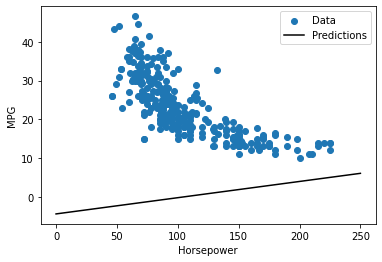

In [ ]:
# 단일 입력변수(x)와 출력변수(y) 데이터를 시각화하기 위한 함수 정의
def plot_horsepower(x, y):
  plt.scatter(train_X['Horsepower'], train_y, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

# 현재의 선형 모델(학습 전)
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

plot_horsepower(x, y)

In [ ]:
# 최적화 방법 정의
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

## (4) Training

In [ ]:
%%time
# 100 epoch에 대한 훈련을 실행하고 진행 과정 기록
history = horsepower_model.fit(
    train_X['Horsepower'],
    train_y,
    epochs=100,  
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 1s 28ms/step - loss: 22.8691 - val_loss: 22.9409
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 22.0620 - val_loss: 22.1410
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 21.2664 - val_loss: 21.3404
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 20.4628 - val_loss: 20.5407
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 19.6612 - val_loss: 19.7405
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 18.8610 - val_loss: 18.9405
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 18.0608 - val_loss: 18.1407
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 17.2775 - val_loss: 17.3645
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 16.4916 - val_loss: 16.5828
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 15.7107 - val_loss: 15.7881
Epoch 1

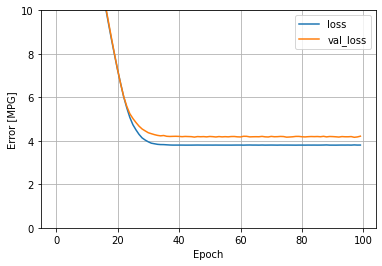

In [ ]:
# 훈련과정을 시각화하기 위한 함수 정의
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

# 훈련과정 시각화
plot_loss(history)  

## (5) Evaluation

8/8 [==============================] - 0s 2ms/step


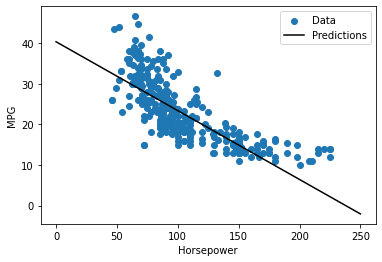

In [ ]:
# 테스트 결과 수집
test_results = {}
test_results['horsepower_model'] = horsepower_model.evaluate( test_X['Horsepower'], test_y)

# 테스트 결과 시각화
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x) 
plot_horsepower(x, y)

# Multiple linear regression (다중 선형 회귀)

## (3) Build the model

In [ ]:
# Multiple linear regression 모델 생성
linear_model = tf.keras.Sequential([
    input_layer,
    layers.Dense(units=1)
])
 
# 생성한 Linear regression 모델의 구조 확인 
linear_model.summary()

# 최적화 방법 정의
# mean_absolute_error는 절댓값 에러임
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


## (4) Training

In [ ]:
%%time
# 100 epoch에 대한 훈련을 실행하고 진행 과정 기록
history = linear_model.fit(train_X, train_y, epochs=100, validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 1s 38ms/step - loss: 22.9287 - val_loss: 22.9272
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 22.0627 - val_loss: 22.2201
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 21.2456 - val_loss: 21.5054
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 20.4149 - val_loss: 20.7645
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 19.6286 - val_loss: 20.0745
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 18.7858 - val_loss: 19.3435
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 17.9653 - val_loss: 18.6256
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 17.1492 - val_loss: 17.8887
Epoch 9/100
8/8 [==============================] - 0s 28ms/step - loss: 16.3438 - val_loss: 17.1868
Epoch 10/100
8/8 [==============================] - 0s 15ms/step - loss: 15.5097 - val_loss: 16.4623

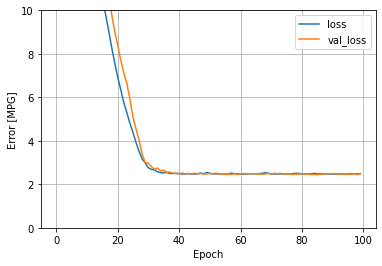

In [ ]:
# 훈련과정 시각화
plot_loss(history)  

## (5) Evaluation

3/3 [==============================] - 0s 5ms/step - loss: 2.5215
{'horsepower_model': 3.6446900367736816, 'linear_model': 2.5214741230010986}
3/3 [==============================] - 0s 6ms/step


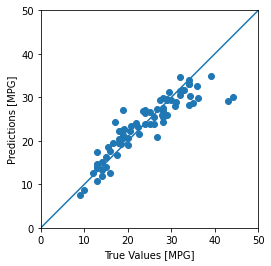

In [ ]:
# Evaluation
test_results['linear_model'] = linear_model.evaluate(test_X, test_y)

# 기존 모델과의 비교
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T
print(test_results)

# 훈련된 모델로 예측하기
test_predictions = linear_model.predict(test_X).flatten()

# 예측 결과 시각화
# 다중 선형회귀이므로 시각화를 x축은 실측값, y축은 계산한값으로 봄 -> 점이 가운데일 수록 좋은 성능
a = plt.axes(aspect='equal')
plt.scatter(test_y, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)  